In [2]:
import numpy as np
import pandas as pd

import os
print(os.listdir("../input"))

['kkbox-music-recommendation-challenge', 'recom-data']


In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import datetime
import math

## С помощью приведенной ниже функции, можно добиться того, чтобы датасеты занимали меньше памяти

In [29]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [30]:
train = reduce_mem_usage(pd.read_csv('/kaggle/input/recom-data/train.csv/train.csv'))
test = reduce_mem_usage(pd.read_csv('/kaggle/input/recom-data/test.csv/test.csv'))
sei = pd.read_csv('/kaggle/input/recom-data/song_extra_info.csv/song_extra_info.csv')
members = pd.read_csv('/kaggle/input/recom-data/members.csv/members.csv',parse_dates=['registration_init_time','expiration_date'])
songs = pd.read_csv('/kaggle/input/recom-data/songs.csv/songs.csv')

Memory usage of dataframe is 337.71 MB
Memory usage after optimization is: 84.59 MB
Decreased by 75.0%
Memory usage of dataframe is 117.04 MB
Memory usage after optimization is: 44.23 MB
Decreased by 62.2%


## Задаем функцию для корректного отображения значения года


In [32]:
def get_codes(isrc):
    if pd.isnull(isrc):
        return np.nan
    else:
        if int(str(isrc)[5:7]) > 17:
            temp =  1900+int(str(isrc)[5:7])
        else:
            temp = 2000+int(isrc[5:7])
        return temp

In [33]:
sei['year'] = sei['isrc'].apply(lambda x: get_codes(x))
sei.sample(10)

,song_id,name,isrc,year
1821584,YpjFYJ4rbtyzmgpmwdlJMliPeWSo78x1EJE2xENN2P4=,Truth And Rights,USA2P0501185,2005.0
1838462,zC5DmKll6o1lkINHkfQN3EQYdF5sD33SqACHBG9MvVY=,Dump Dump,TCACR1628894,2016.0
450046,iUhtT4+fuupGy14B/2OfOz52xBKH/eW2X8e6fjuWKyQ=,Filthy And Fried,USATO1600214,2016.0
922962,4De6Mhk+xeJeMkqR8zd6bSyTIG7NOOrDOl6eIfm+CBI=,Startin' out Again,GBPS81528923,2015.0
2080967,X0rjayMBoKajOjSrI7w7/tsGZEkxwSNSiQ44VStT4n4=,Brow Beaten,GBGEY0900123,2009.0
911551,oVp4IBQTlgcVGp0RLBiIuZU/VW7g29//9eciOyPv8QM=,Never Surrender,GBBLY8200299,1982.0
1466374,0uDA6IsGS5/4wwTyk6xJSigJHEhLRC/IVR4RN9hkLJk=,Images| Book 2| L. 111: No. 1. Cloches à trave...,GBPS81517723,2015.0
893994,1z6HZPYmdj1RAC/aXurZ5i+c0z5PFAlKTErymlAgTEs=,Floading,DET751400033,2014.0
1791881,WH5/L+MdeCeEmsaIVJ7VMmMox7KyhLlXEakF7NfkCFo=,Danza Húngara No. 5 in F-Sharp Minor,QMFME1485786,2014.0
1176370,g+Q6V1Y0VaWeQdK6ajZCIVqGokUN+VSJuPsOYOJM/Ao=,買本書回去看吧,TWB831396709,2013.0


## Feature Engineering

In [34]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['registration_year'] = members['registration_init_time'].dt.year
members['expiration_year'] = members['expiration_date'].dt.year
members.drop(columns = ['registration_init_time' , 'expiration_date'] , inplace = True)
members.head()

,msno,city,bd,gender,registered_via,membership_days,registration_year,expiration_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2223,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,725,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,457,2016,2017
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,1,2015,2015
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,138,2017,2017


In [35]:
# Extending columns
# merging the database
train = train.merge(songs , on='song_id' , how='left')
train = train.merge(members , on = 'msno' , how='left')
train = train.merge(sei , on = 'song_id' , how='left')
test  = test.merge(songs , on='song_id' , how='left')
test = test.merge(members , on = 'msno' , how = 'left')
test =  test.merge(sei , on = 'song_id' , how = 'left')
del sei ,members , songs
gc.collect()

417

In [36]:
print(train['song_length'].isnull().value_counts()/train.shape[0])
train['song_length'].fillna(train['song_length'].mean() , inplace = True)
train['song_length'] = train['song_length'].astype(np.uint32)
print(train['language'].isnull().value_counts()/train.shape[0])
train['language'].fillna(train['language'].mode().values[0] , inplace= True)
train['language'] = train['language'].astype(np.int8)
test['song_length'].fillna(test['song_length'].mean() , inplace = True)
test['song_length'] = test['song_length'].astype(np.uint32)
test['language'].fillna(test['language'].mode().values[0] , inplace= True)
test['language'] = test['language'].astype(np.int8)

False    0.999985
True     0.000015
Name: song_length, dtype: float64
False    0.99998
True     0.00002
Name: language, dtype: float64


In [37]:
def genre_count(genre):
    if genre == 'no_genre_id':
        return 0
    else :
        return genre.count('|') + 1
print(train['genre_ids'].isnull().value_counts()/train.shape[0])
train['genre_ids'].fillna('no_genre_id' , inplace= True)
train['genre_ids_count'] = train['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
test['genre_ids'].fillna('no_genre_id' , inplace= True)
test['genre_ids_count'] = test['genre_ids'].apply(lambda x: genre_count(x)).astype(np.int8)
                                                       

False    0.983944
True     0.016056
Name: genre_ids, dtype: float64


In [38]:

def artist_count(art):
    if art=='no_artist_name':
        return 0
    else:
        return art.count('|')+art.count('/') + art.count('//') + art.count(';') + 1
train['artist_name'].isnull().value_counts()
train['artist_name'].fillna('no_artist_name' , inplace = True)
train['artist_count'] = train['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)
test['artist_name'].fillna('no_artist_name' , inplace = True)
test['artist_count'] = test['artist_name'].apply(lambda x : artist_count(x)).astype(np.int8)

In [39]:
def  count_composer(comp):
    if comp=='no_composer':
        return 0
    else:
        return comp.count('|')+comp.count('/') + comp.count('//') + comp.count(';') + 1
def  count_lyricist(lyr):
    if lyr=='no_lyricist':
        return 0
    else:
        return lyr.count('|')+lyr.count('/') + lyr.count('//') + lyr.count(';') + 1

In [40]:
train['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
train['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricist_count'] = train['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)
test['composer'].fillna('no_composer',inplace=True)
test['composer_count'] = test['composer'].apply(lambda x: count_composer(x)).astype(np.int8)
test['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist_count'] = test['lyricist'].apply(lambda x: count_lyricist(x)).astype(np.int8)

In [41]:
dict_count_song_played_train = {k: v for k, v in train['song_id'].value_counts().iteritems()}
dict_count_song_played_test = {k: v for k, v in test['song_id'].value_counts().iteritems()}
def return_number_played(x):
    try:
        return dict_count_song_played_train[x]
    except KeyError:
        try:
            return dict_count_song_played_test[x]
        except KeyError:
            return 0
train['number_of_time_played'] = train['song_id'].apply(lambda x: return_number_played(x))
test['number_of_time_played'] = test['song_id'].apply(lambda x: return_number_played(x))

In [42]:
dict_user_activity = {k:v for k,v in pd.concat([train['msno'] , test['msno']] , axis = 0).value_counts().iteritems()}
def return_user_activity(x):
    try:
        return dict_user_activity[x]
    except KeyError:
        return 0
train['user_activity_msno'] = train['msno'].apply(lambda x: return_user_activity(x))
test['user_activity_msno'] = test['msno'].apply(lambda x: return_user_activity(x))

In [44]:
train_col = list(train.columns)
test_col = list(test.columns)
for f in test_col :
    if f not in train_col:
        print('ERROR !!!  Column from Test not found in train is ->' , f)
label_encoding = ['source_system_tab', 'source_screen_name',
       'source_type','gender']
drop = ['msno', 'song_id' , 'isrc','artist_name',
       'composer', 'lyricist','name','genre_ids']
min_max_scaling = ['number_of_time_played', 'user_activity_msno','membership_days', 'song_length']

ERROR !!!  Column from Test not found in train is -> id


In [45]:
for f in label_encoding:
    lb = LabelEncoder()
    lb.fit(list(train[f].values) + list(test[f].values))
    train[f] = lb.transform(list(train[f].values))
    test[f] = lb.transform(list(test[f].values))
for f in min_max_scaling:
    ms = MinMaxScaler()
    train[f] = ms.fit_transform(train[[f]])
    test[f] = ms.transform(test[[f]])

## Приводим некоторые колонки к нужному типу

In [46]:
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [47]:
train.sample(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
6051773,OswQwAmPaPS/6bmVxcKJEKZ4TohruejcYexNQlO818A=,396vn8dkHRgOa3fQm5o/FJzQVJgo8zBnogjbFuVkC3I=,3,0,0,0,0.020843,465,Lady Gaga,Lady Gaga| R. Kelly| Martin Bresso| William Gr...,...,2017,Do What U Want,USUM71310776,2013.0,1,1,5,0,0.001789,0.184847
5264635,GG+fJWR9qzq3TeK00hcZ35UoL7jrGaaaK5PTMv/jKl0=,9YYrODwrXpDcCjOJypHROv3f5z40y11QlmgQjmzp2vQ=,0,11,7,0,0.016772,1616|1609,Mike Perry,Mikael Persson| Sara Hjellström| Dimitri Vange...,...,2017,The Ocean,SE3AA1600005,2016.0,2,1,5,3,0.304395,0.040796
321295,WVq3HzG8Y5xITkOcruDj/92G/MVll5qX0IqEDc7/FGM=,XzieCAtzxpv7uP08RVpiUGib5udaAXHFeTCD/nbbbEk=,0,4,0,0,0.024631,465,江蕙 (Jody Jiang),謝誌豪,...,2016,花香,NaN,NaN,1,1,1,1,0.009304,0.004561
315297,IHTD0ohBacT3VbZ5sRc8OEMWxb/F53bHmLq5tqWqTJY=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,0,11,7,1,0.023677,465,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,...,2017,FLY OUT,TWA451512031,2015.0,1,1,1,1,0.751431,0.078804
6116380,bliccNjsznPGt14bJkShf39zb1Bain2VIn3AsoFI1Gs=,abq57hjwEFvbuwssAOZcFUi/noOMUo6/2E0FMnwA+GI=,7,1,11,0,0.018516,458,小男孩樂團 (Men Envy Children),Skot Suyama陶山,...,2017,心中的圖畫,TWA471596005,2015.0,1,1,1,1,0.012525,0.010136
7257492,pQBUuOxtRWK4S17uY5Gg/HKlKG5kJpsBfzCbyOUclmc=,ls2DaFwqfKpflreqd5rUgWlHA+A22a5DT+NRRmUDD8I=,7,0,0,0,0.022888,1259,熱狗 (MC HotDog),姚中仁/張震嶽,...,2017,好無聊,TWA451294107,2012.0,1,1,2,2,0.006871,0.135817
5570817,vDSZfzzr6UA4zRJFaoqrFcKKy0Yij+3s2OPJY7I+OVY=,vwkOqGQHYpNhpHv6/I7cnJg+ONqkLGKo1YbfGw7Kvno=,3,8,4,1,0.028368,465,David Garrett,no_composer,...,2017,Music,GBUM71205843,2012.0,1,1,0,0,0.000072,0.026226
3778888,GhXA1tFLckIP5rKQ3SzC/w7pbwGE6BEOn9RhYlYgg/0=,TwdvXy0KJ7Lmv7f/2eCXj/FMhUR0ZH8r6w15/jXDdfU=,0,4,10,1,0.017437,465,The DEY,Emilio Cancio-Bello| Timbaland| Jonkenum Spive...,...,2018,Get The Feeling,USSM10702998,2007.0,1,1,7,7,0.003364,0.120360
3660534,YiCKqtqJVA/Y7FQIiPh6EBbStdyxEg1czSA2VInydLA=,Dh9QlpCW3TToGvERbPQXl/zxNFwt0MqH6CBn74kXf/A=,3,8,4,1,0.020374,921,Various Artists,麥振鴻,...,2017,不可說,NaN,NaN,1,1,1,3,0.019825,0.017104
3766086,pKGPkeyTyyGl9dBlC0cmfOIs2heG/sEbZows5baen3s=,IdgWSFhzE1z85ySSF4I+IXb/KTRYPh5e2LjU59XaQ14=,3,22,11,1,0.016234,465,Dance Party X'mas,no_composer,...,2017,Joy To The World (普世歡騰),NaN,NaN,1,1,0,0,0.000429,0.107057


In [49]:
X_train = train.drop(columns = ['target'] , axis = 1)
Y_train = train['target'].values
X_test = test.drop(columns = ['id'] , axis = 1)
ids = test['id'].values
#del train , test
gc.collect()
train_set = lgb.Dataset(X_train , Y_train)

In [51]:
test.head(5)

,id,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,3,8,3,0.020528,458,梁文音 (Rachel Liang),Qi Zheng Zhang,...,2017,愛其實很殘忍,TWUM71400047,2014.0,1,1,1,0,0.049599,0.020018
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,3,8,3,0.029407,465,林俊傑 (JJ Lin),林俊傑,...,2017,她說,TWB671005201,2010.0,1,1,1,2,0.435800,0.020018
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,0,22,10,0.028986,2022,Yu Takahashi (高橋優),Yu Takahashi,...,2016,subarashiki nichijo,JPWP01070260,2010.0,1,1,1,1,0.000286,0.016724
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,6,16,8,0.026157,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,...,2017,Hold Me| Thrill Me| Kiss Me| Kill Me,GBAAN0201228,2002.0,1,1,4,0,0.002147,0.083238
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,6,16,8,0.018082,873,Yoga Mr Sound,Neuromancer,...,2017,Om Yoga,ITO101121898,2011.0,1,1,1,0,0.000286,0.083238


In [53]:
test['msno'].nunique()

25131

## Переходим к модели. Для этой задачи решил использовать фреймврок LightGBM

In [54]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 200,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=train_set,  valid_sets=train_set, verbose_eval=5)

[5]	training's auc: 0.73649
[10]	training's auc: 0.748532
[15]	training's auc: 0.755488
[20]	training's auc: 0.75938
[25]	training's auc: 0.763052
[30]	training's auc: 0.765725
[35]	training's auc: 0.768757
[40]	training's auc: 0.772248
[45]	training's auc: 0.774507
[50]	training's auc: 0.776945
[55]	training's auc: 0.778786
[60]	training's auc: 0.780391
[65]	training's auc: 0.781932
[70]	training's auc: 0.783381
[75]	training's auc: 0.784829
[80]	training's auc: 0.78585
[85]	training's auc: 0.787255
[90]	training's auc: 0.788674
[95]	training's auc: 0.789973
[100]	training's auc: 0.79109
[105]	training's auc: 0.792017
[110]	training's auc: 0.793042
[115]	training's auc: 0.794287
[120]	training's auc: 0.795127
[125]	training's auc: 0.796257
[130]	training's auc: 0.797302
[135]	training's auc: 0.798215
[140]	training's auc: 0.798805
[145]	training's auc: 0.799669
[150]	training's auc: 0.800411
[155]	training's auc: 0.801229
[160]	training's auc: 0.801738
[165]	training's auc: 0.80234
[1

## После обучения делаем предсказания на тестовой выборке

In [55]:
pred_test = model_f1.predict(X_test)
print('Saving Predictions')
sub = pd.DataFrame()
sub['id'] = ids
sub['target'] = pred_test
sub.to_csv('1st_submission.csv' , index = False , float_format ='%.5f' )

Saving Predictions


In [57]:
sub.head()

,id,target
0,0,0.409095
1,1,0.445085
2,2,0.155031
3,3,0.108458
4,4,0.103390


In [58]:
X_test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,expiration_year,name,isrc,year,genre_ids_count,artist_count,composer_count,lyricist_count,number_of_time_played,user_activity_msno
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,3,8,3,0.020528,458,梁文音 (Rachel Liang),Qi Zheng Zhang,no_lyricist,...,2017,愛其實很殘忍,TWUM71400047,2014.0,1,1,1,0,0.049599,0.020018
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,3,8,3,0.029407,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,...,2017,她說,TWB671005201,2010.0,1,1,1,2,0.435800,0.020018
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,0,22,10,0.028986,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,...,2016,subarashiki nichijo,JPWP01070260,2010.0,1,1,1,1,0.000286,0.016724
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,6,16,8,0.026157,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,no_lyricist,...,2017,Hold Me| Thrill Me| Kiss Me| Kill Me,GBAAN0201228,2002.0,1,1,4,0,0.002147,0.083238
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,6,16,8,0.018082,873,Yoga Mr Sound,Neuromancer,no_lyricist,...,2017,Om Yoga,ITO101121898,2011.0,1,1,1,0,0.000286,0.083238


In [64]:
dt = pd.DataFrame({
    'id': ids,
    'user_id': X_test['msno'],
    'song_id': X_test['song_id'],
    'target': sub['target'] 
})

dt.sort_values('user_id').head()

,id,user_id,song_id,target
425995,425995,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,51+afDyA8HKSGXcJy4vxoc8c+9x2qgriQrjjkX8wD1c=,0.567357
2075308,2075308,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,+QIN3k3cgS0F4Js3zKfkBuYeKD4wJYOO4/skMiKERIs=,0.646099
418924,418924,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,zpX0OnT5wqRtsfsw8V1K78m0V3drEInc+IRctbrRcqE=,0.636662
1800384,1800384,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,d2k4F/IYpmudgfCxsRAXVHBdYHPfcWmhCYmjdXxigLE=,0.682112
1094199,1094199,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,dj/CJYggc55pGEp9ygeCMUHy4lseKOFspTSOeGaTDzc=,0.567357


In [88]:
#dt['rank'] = dt.groupby('user_id')['target'].rank(ascending=False)
#dt['rank'] = dt['rank'].astype('int')
dt['pred_target'] = np.where(pred_test >= 0.5, 1, 0)

In [89]:
dt[dt['user_id'] == '++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU='].sort_values(['user_id', 'rank'], ascending = ['True', 'False'])

,id,user_id,song_id,target,rank,pred_target
2078768,2078768,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,IKMFuL0f5Y8c63Hg9BXkeNJjE0z8yf3gMt/tOxF4QNE=,0.889820,1,1
1940059,1940059,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,wBTWuHbjdjxnG1lQcbqnK4FddV24rUhuyrYLd9c/hmk=,0.822763,2,1
2072866,2072866,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,i356q8t0P9emMJq8PsFkY6CGoi34mP3cgXuDpfEDyhY=,0.819805,3,1
2080808,2080808,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,7XjSvrL47/EJD2mNR0e2Ja+ed/Dm0j35tKPQLiO2Hjk=,0.801868,4,1
2077739,2077739,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,Ru7n8Xw2s8LGDsgDhyzWqCWQRWQW9KNPY9qMOFAf5x0=,0.749160,5,1
2076621,2076621,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,wR+LLM957WfBdaXmUsdE9AiGzOVki7yjelGea+0Ze8E=,0.727275,6,1
378161,378161,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,M7j5lGrEZi/LVEfd+bF6th3A762bUl3rxxR3GyXGJQY=,0.720572,7,1
2079867,2079867,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,T7YFpVp/WyTCG1GP/MGmc32ougnXl0qiw67NV7xf83Y=,0.720322,8,1
2079869,2079869,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,lkczjw5PyF8xOmRn3PN71d/BhmgrzVx8qTih4EjsQGQ=,0.714014,9,1
378159,378159,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,lUEOHX1/QRXYZ7Tgsaktz3GWKEHQli4TWJRXwN6wWhg=,0.713673,10,1


In [79]:
train['target']

0          1
1          1
2          1
3          1
4          1
5          1
6          1
7          1
8          1
9          1
10         1
11         1
12         0
13         1
14         1
15         1
16         1
17         1
18         0
19         1
20         1
21         1
22         1
23         1
24         0
25         0
26         0
27         1
28         1
29         1
          ..
7377388    0
7377389    0
7377390    0
7377391    0
7377392    0
7377393    0
7377394    0
7377395    0
7377396    0
7377397    1
7377398    0
7377399    0
7377400    0
7377401    0
7377402    0
7377403    1
7377404    0
7377405    1
7377406    0
7377407    1
7377408    0
7377409    0
7377410    1
7377411    1
7377412    1
7377413    1
7377414    0
7377415    1
7377416    1
7377417    1
Name: target, Length: 7377418, dtype: int8

In [81]:
train_target = train['target']
pred_train = model_f1.predict(X_train)
#print('Saving Predictions')
train_sub = pd.DataFrame()
#train_sub['id'] = ids
train_sub['target'] = pred_train
train_sub.to_csv('train_submission.csv' , index = False , float_format ='%.5f' )

In [85]:
train_dt = pd.DataFrame({
    #'id': ids,
    'user_id': X_train['msno'],
    'song_id': X_train['song_id'],
    'true_target': train_target,
    'predicted_target': train_sub['target'] 
})

train_dt.sort_values('user_id').head()

,user_id,song_id,true_target,predicted_target
3743055,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,DZanD98cLDbuPBiXONSwLFSw8BfI69ErQS23vYJ9UU4=,1,0.572429
2028065,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,E6Fm873UEDPv0LATidt2gKwBZZHww2Q04nxTg15N9iE=,1,0.530238
785721,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0TZ4BKn9YES2upK9ZgKgsAUtUClVKHnct79pnA/iPiQ=,1,0.610110
785720,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,m2YSjnhR3nzx/2WccNYpGWywohyd8fT0xR+skQC9/JQ=,1,0.610110
2973176,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,cXpk2ZXiSgkwGo8iGbswBc0lzucL9AH+j/2khmnmOLI=,0,0.532135


In [90]:
train_dt['pred_target'] = np.where(pred_train >= 0.5, 1, 0)

In [93]:
train_dt[train_dt['user_id'] == '++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU='].sort_values('true_target', ascending = False)

,user_id,song_id,true_target,predicted_target,pred_target
3739613,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,irkZHHxQ5mGCIqSrw6Av02eLQBzCBV1/KeCXozhE3f4=,1,0.663401,1
2984346,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,A4adEjARY3M6bxwMc+K5UzIqD++k6IZmHLFpBKbqkPk=,1,0.482987,0
2982573,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,wKTE8xGiLwugzf3eh08sNOWSnMzyrr35gbFDS8awAQM=,1,0.505385,1
2982572,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,T66MQOMmTS2o5GNUhA/zvmdVM0Hgq7MzCjni2JsGlS4=,1,0.523404,1
2982571,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,6zJYma0DFz169C1ZNhFtiaQBMClMF6K4ohskGqwN7jo=,1,0.505385,1
2982570,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,LHkOjot2EChL9gRNRYTj5230D7GOaBOcpOoUR9EvS4Q=,1,0.482987,0
2980593,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,k5I0/3iExhNekFyCfRC3oAxN7IhgvVqrbzME63Sda9A=,1,0.467812,0
2980592,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,tffET4yeQls3FjTJO08dn7qGgq+Zbl9Fxms77jphz1I=,1,0.477218,0
2980591,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,ruJH9YywRZ3OZjLhlCQumFtzYm1CSF16Nj4QOz7XJj8=,1,0.523404,1
2978613,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,BU2ejeR67eCDxf2qDCavwMs8YJ8qqZGHfznENg6iYKk=,1,0.549211,1


In [104]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [99]:
from sklearn.metrics import ndcg_score

ndcg_score_at_20 = ndcg_score(train_dt['target'], train_dt['pred_target'], k=20)
print(f"NDCG@20: {ndcg_score_at_20}")

ImportError: cannot import name 'ndcg_score'

## В Kaggle-ноутбуке не получилось применить ndcg_score из sklearn.metrics. Пришлось досчитать метрику в Google Colab)

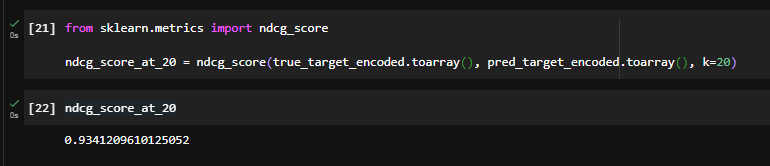

In [103]:
train_dt.to_csv('ndcg_submission.csv' , index = False , float_format ='%.5f' )